# Load packages 

In [2]:
import torch
import torchvision
import torch.nn as nn
import scipy.stats
import scipy.io
import scipy.sparse
from scipy.io import loadmat
import torch.distributions as td
import logging
import os

class TensorFlowLogger:
    def __init__(self):
        self.logger = logging.getLogger('tensorflow')
        self.logger.setLevel(logging.WARNING)
        self.logger.addHandler(logging.FileHandler(os.path.join(os.getcwd(), 'tensorflow.log')))

    def set_log_level(self, level):
        self.logger.setLevel(level)

    def get_log_level(self):
        return self.logger.level

    def log(self, message, level=logging.INFO):
        if self.logger.isEnabledFor(level):
            self.logger.log(level, message)

logger = TensorFlowLogger()
logger.set_log_level(logging.ERROR)

from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import BayesianRidge
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from statistics import mean

import pandas as pd
import numpy as np

from MIWAE import *
from optimization_tools import *
from missing_mechanism import *
from comparison_tools import *
from plot_tools import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


In [3]:
def create_complete_dataset(seed,n,c,noise,modSimu,k=None,mu=None,Sigma=None,fn=None):
    if (modSimu=="linear"):
        X=np.random.multivariate_normal(size=n,mean=mu,cov=Sigma)
        tab=np.empty((n,c))
        for i in range (c):
            if i<np.around(k*c):
        
                tab[:,i]=X[:,0]
            else :
                tab[:,i]=X[:,1]
        tab+=np.array(np.random.normal(loc=0,scale=noise,size=(n,c)))

    elif (modSimu=="non-linear"):
        un=np.random.uniform(low=0,high=2*np.pi,size=n)
        tab=np.empty((n,c))
        for i in range(c) :
            tab[:,i]=np.sin(fn*((2*np.pi*i/c+un)))
        tab+=np.array(np.random.normal(loc=0,scale=noise,size=(n,c)))
    return tab

In [4]:
def missing_method(raw_data, mechanism='mcar',t=0.2) :
    data = raw_data.copy()
    rows, cols = data.shape
    # missingness threshold
    if mechanism == 'mcar' :
        # uniform random vector
        v = np.random.uniform(size=(rows, cols))
        # missing values where v<=t 
        # mask is a matrix where mij equals to True if vij<=t and False otherwise
        mask = (v<=t)
        data[mask] = np.nan 
    elif mechanism == 'mar' :
        nump=raw_data.to_numpy()
        mask=MAR_mask(X=nump,p=t,p_obs=0.0)
        data[mask]=np.nan

    elif mechanism=="mnar":
        nump=raw_data.to_numpy()
        mask=MNAR_self_mask_logistic(nump,p=t)
        data[mask]=np.nan
    else :
        print("Error : There is no such mechanism")
        raise
        
    return data, ~mask

# Train function

In [6]:
def train_MIWAE_standardization_mean_std(encoder,decoder,optimizer,d,p_z,miss_data,raw_data,mean_0,std_0,device,n_epochs=2001,bs=64,K=20,verbose=False):
    n,p=raw_data.shape
    miwae_loss_train=np.array([])
    mse_train=np.array([])
    mse_train2=np.array([])
    mask1=np.isfinite(miss_data)
    mask=np.copy(mask1)
    xhat0=np.copy(miss_data)
    xhat0[np.isnan(miss_data)]=0
    xhat = np.copy(xhat0)# This will be out imputed data matrix
    xfull=np.copy(raw_data)
    
    encoder.apply(weights_init)
    decoder.apply(weights_init)
    old_mean=mean_0
    old_std=std_0
    list_mean=[mean_0]
    list_std=[std_0]
    list_ep=[0]

    for ep in range(1,n_epochs):
        perm = np.random.permutation(n) # We use the "random reshuffling" version of SGD
        batches_data = np.array_split(xhat0[perm,], n/bs)
        batches_mask = np.array_split(mask[perm,], n/bs)
        for it in range(len(batches_data)):
            optimizer.zero_grad()
            encoder.zero_grad()
            decoder.zero_grad()
            b_data = torch.from_numpy(batches_data[it]).float().to(device)
            b_mask = torch.from_numpy(batches_mask[it]).float().to(device)
            loss = miwae_loss(encoder=encoder,decoder=decoder,d=d,p=p,K=K,p_z=p_z,iota_x = b_data,mask = b_mask)
            loss.backward()
            optimizer.step()
        if ep % 20== 1 and ep>100:
            if verbose:
                
                print('Epoch %g' %ep)
                print('MIWAE likelihood bound  %g' %(-np.log(K)-miwae_loss(encoder=encoder,decoder=decoder,d=d,p=p,K=K,p_z=p_z,iota_x = torch.from_numpy(xhat0).float().to(device),mask =torch.from_numpy(mask).float().to(device)).cpu().data.numpy())) # Gradient step      
    
        ### Now we do the imputation
    
            xhat[~mask] = miwae_impute(encoder=encoder,decoder=decoder,d=d,p=p,p_z=p_z,device=device,iota_x = torch.from_numpy(xhat0).float().to(device),mask = torch.from_numpy(mask).float().to(device),L=10).cpu().data.numpy()[~mask]
            err = np.array([mse(xhat,xfull,mask)])
            mse_train = np.append(mse_train,err,axis=0)
            destandardized_data=np.multiply(pd.DataFrame(xhat),old_std)+old_mean
            new_mean=np.mean(destandardized_data,0)
            new_std=np.std(destandardized_data,0)
            new_standardized_data=(destandardized_data-new_mean)/new_std
            list_mean.append(new_mean)
            list_std.append(new_std)
            list_ep.append(ep)
            old_mean=new_mean
            old_std=new_std
            xhat0=new_standardized_data.to_numpy()
            xhat=xhat0.copy()
            if verbose :
                
                print('Imputation MSE  %g' %err)
                print('-----')
    return (list_mean,list_std,list_ep)

In [7]:
def mean_std_MIWAE_standardization(raw_data,K,d,mechanism,prop_NA,h=64,device=device):
    mean=[]
    std=[]
    ep=[]
    xcomp=(raw_data-np.mean(raw_data,0))/np.std(raw_data,0)
    for mech in mechanism :
        miss_tmp,mask=missing_method(raw_data,mechanism=mech,t=prop_NA)
        miss=(miss_tmp-np.nanmean(miss_tmp,0))/np.nanstd(miss_tmp,0)
        n,p=raw_data.shape
        p_z=prior(d=d,device=device)
        encoder,decoder=build_encoder_decoder(p,h=h,d=d)
        optimizer=build_optimizer(encoder=encoder,decoder=decoder)
        list_mean,list_std,list_ep=train_MIWAE_standardization_mean_std(encoder=encoder,decoder=decoder,optimizer=optimizer,d=d,mean_0=np.nanmean(miss_tmp,0),std_0=np.nanstd(miss_tmp,0),p_z=p_z,miss_data=miss,raw_data=xcomp,device=device,K=K,verbose=False,n_epochs=501)
        mean.append(list_mean)
        std.append(list_std)
        ep.append(list_ep)
    return (mean,std,ep)

    

In [8]:
data=pd.DataFrame(create_complete_dataset(444,300,9,modSimu="linear",k=0.4,mu=[1,3],Sigma=[[1,0.2],[0.2,3]],noise=0.9))

In [9]:
mean,std,ep=mean_std_MIWAE_standardization(data,20,2,["mar","mnar"],0.4)

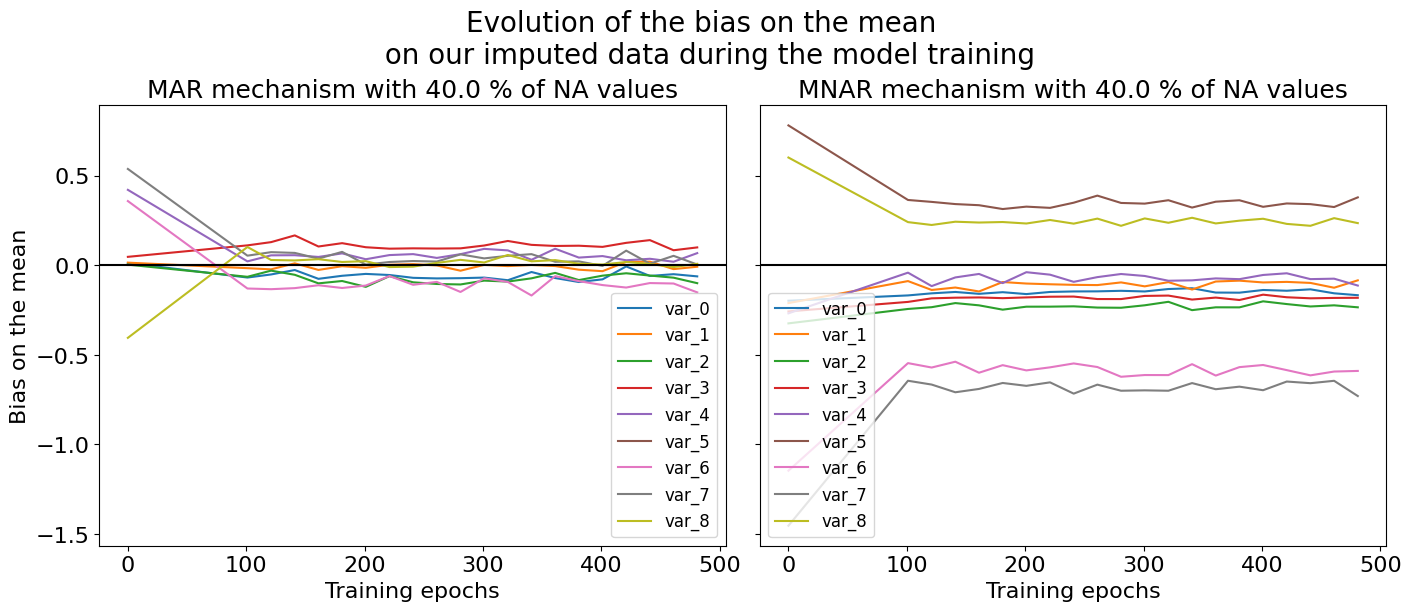

In [10]:
plot_mean_MIWAE(data,mean,ep,["mar",'mnar'],0.4)

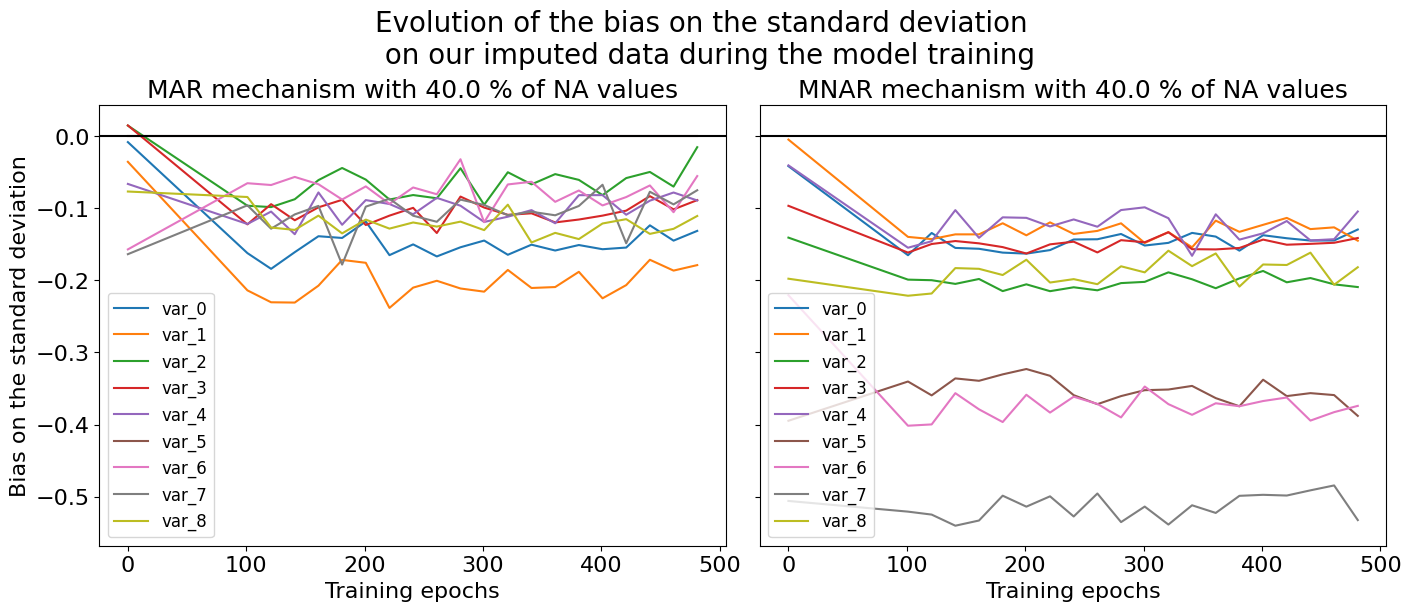

In [12]:
plot_std_MIWAE(data,std,ep,["mar","mnar"],0.4)

In [13]:
seed=641
n=250
c=7
modSimu="linear"
k=0.4
mu=[1,1]
Sigma=np.array([[1,0.1],[0.1,1]])
data=pd.DataFrame(create_complete_dataset(seed=seed,n=n,c=c,modSimu=modSimu,k=k,mu=mu,Sigma=Sigma,noise=0.6))
standardized_data = (data - np.mean(data,0))/np.std(data,0)


In [14]:
miss,mask=missing_method(raw_data=standardized_data,mechanism="mar",t=0.3)


In [15]:
d=2
h=64
K=20
n,p=miss.shape

In [12]:
## Build the prior 

p_z=prior(d=d,device=device)

## Build the decoder and encoder

encoder,decoder=build_encoder_decoder(p,h=h,d=d)

## Build the optimizer 

optimizer=build_optimizer(encoder=encoder,decoder=decoder)



In [10]:
mse_train=train_MIWAE_standardization(encoder=encoder,decoder=decoder,optimizer=optimizer,d=d,mean_0=np.mean(data,0),std_0=np.std(data,0),p_z=p_z,miss_data=miss,raw_data=standardized_data,device=device,K=K,verbose=True,n_epochs=501)


Epoch 101
MIWAE likelihood bound  -5.97294
Imputation MSE  0.508453
-----
Epoch 121
MIWAE likelihood bound  -7.03523
Imputation MSE  1.81545
-----
Epoch 141
MIWAE likelihood bound  -5.61146
Imputation MSE  0.621406
-----
Epoch 161
MIWAE likelihood bound  -6.24942
Imputation MSE  0.786586
-----
Epoch 181
MIWAE likelihood bound  -6.00774
Imputation MSE  0.586439
-----
Epoch 201
MIWAE likelihood bound  -5.77387
Imputation MSE  0.574516
-----
Epoch 221
MIWAE likelihood bound  -6.13887
Imputation MSE  0.594746
-----
Epoch 241
MIWAE likelihood bound  -5.67198
Imputation MSE  0.552183
-----
Epoch 261
MIWAE likelihood bound  -6.09102
Imputation MSE  0.565652
-----
Epoch 281
MIWAE likelihood bound  -5.64306
Imputation MSE  0.535627
-----
Epoch 301
MIWAE likelihood bound  -5.99012
Imputation MSE  0.556747
-----
Epoch 321
MIWAE likelihood bound  -5.68308
Imputation MSE  0.542382
-----
Epoch 341
MIWAE likelihood bound  -5.96953
Imputation MSE  0.532544
-----
Epoch 361
MIWAE likelihood bound  -5.62

# Test 

## With standardization on the whole dataset (before missing values)

In [5]:
seed_1=1563
n_1=300
cov_1=8
var_1=0.5
mod_1="non-linear"
fn_1=0.6
Sigma_1=np.array([[1,0.4],[0.4,12]])
exp_1=pd.DataFrame(create_complete_dataset(seed=seed_1,n=n_1,c=cov_1,modSimu=mod_1,fn=fn_1,noise=var_1))
X_1=(exp_1 - np.mean(exp_1,0))/np.std(exp_1,0)


In [6]:
opti_1,mask_1=missing_method(raw_data=X_1,mechanism="mnar",t=0.3)

The minimum mse value is obtained for a dimension of the latent space d: 1 and a number of iteration for the importance sampling of the MIWAE bound construction K :60.0


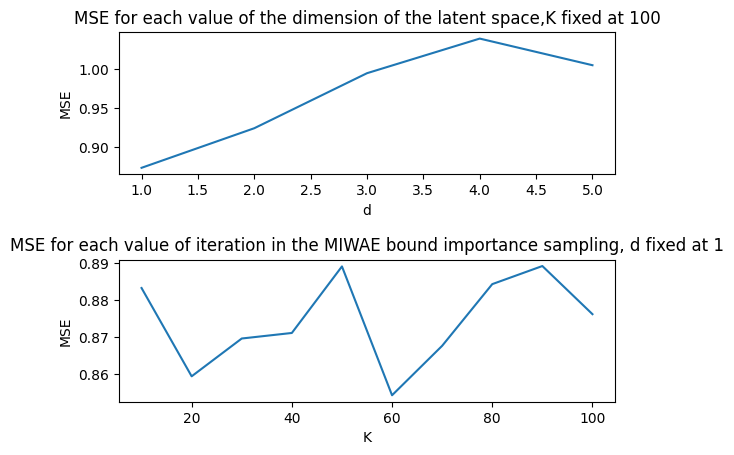

In [7]:
optimize_MIWAE_param(d_array=np.linspace(1,5,5),K_array=np.linspace(10,100,10),full_data=X_1,miss_data=opti_1,mask=mask_1)

The minimum mse value is obtained for a dimension of the latent space d: 1 and a number of iteration for the importance sampling of the MIWAE bound construction K :90.0


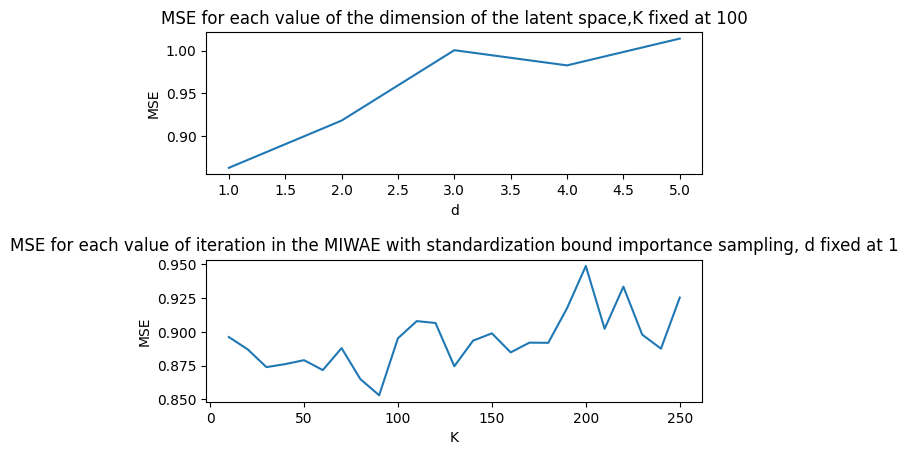

In [8]:
optimize_MIWAE_std_param(d_array=np.linspace(1,5,5),K_array=np.linspace(10,250,25),full_data=X_1,miss_data=opti_1,mask=mask_1)

The minimum mse value is obtained for a learning rate : 0.0005


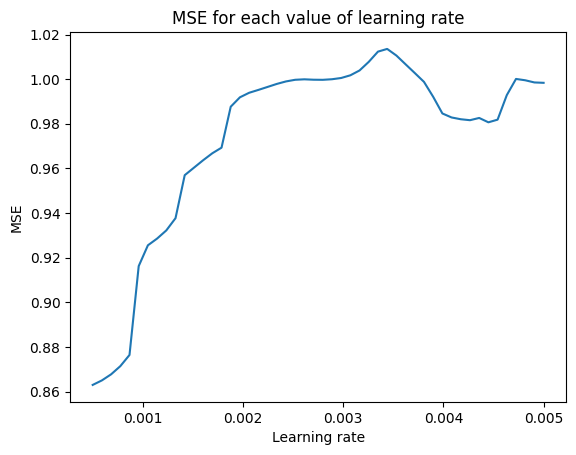

In [9]:
optimize_MIDA_param(lr_array=np.linspace(0.005,0.0005,50),full_data=X_1,miss_data=opti_1,mask=mask_1)

The minimum mse value is obtained for a number of trees in the forest of : 10.0


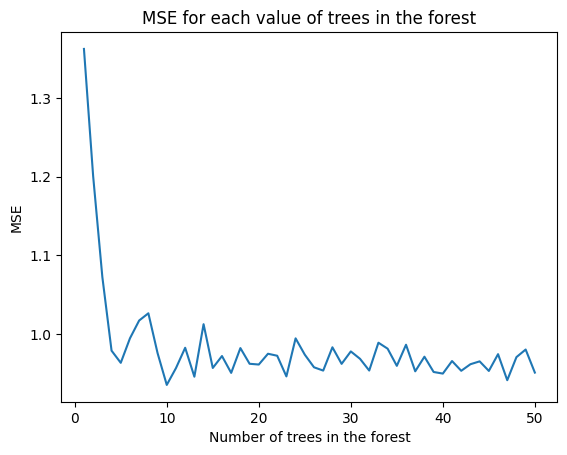

In [10]:
optimize_RF_param(n_est_array=np.linspace(1,50,50),full_data=X_1,miss_data=opti_1,mask=mask_1)

In [11]:
mech_1=["mar","mnar"]
meth_1=["MIWAE","MIWAE_standardization","MIDA","RF"]
prop_1=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
sim_1=10
M_1=1000


# MIDA 

la_1= [64,64,64] 
lr_1=0.0005
in_1=0.8
trb_1=32
tr_1=100
MIDA_1=[la_1,lr_1,in_1,trb_1,seed_1,tr_1]

# MIWAE
d_1=1
h_1=64
K_1=60
tr_M_1=501
MIWAE_1=[d_1,h_1,K_1,tr_M_1]
# MIWAE standardization

d_str_1=1
h_str_1=64
K_str_1=90
tr_M_str_1=501
MIWAE_std_1=[d_str_1,h_str_1,K_str_1,tr_M_str_1]

# RF
iter_1=10
est_1=10
RF_1=[iter_1,est_1]



In [12]:
exp1_res,exp1_boxplot=comparison(full_data=X_1,missing_mecha=mech_1,prop_NA=prop_1,comp_methods=meth_1,nb_simu=sim_1,M=M_1,device=device,Miwae_param=MIWAE_1,Mida_param=MIDA_1,Rf_param=RF_1,Miwae_std_param=MIWAE_std_1,save=False)


MAR
Computation for 10.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 20.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 30.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 40.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 50.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 60.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 70.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 80.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 90.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
MNAR
Computation for 10.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 20.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 30.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 40.

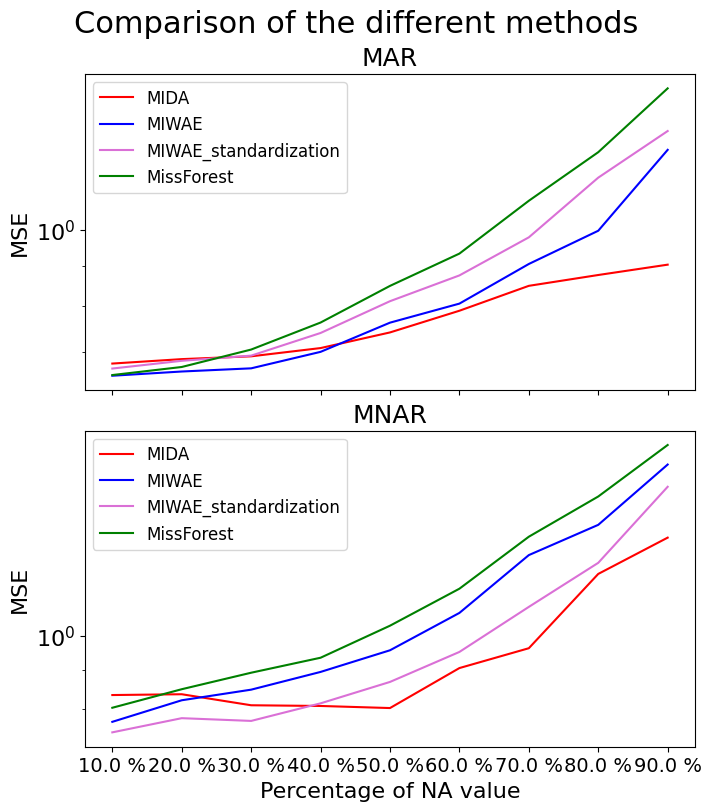

In [13]:
plot_result(exp1_res,meth_1,save=True,name="cheating.png")

In [14]:
opti_std_1_tmp,mask_std_1=missing_method(raw_data=exp_1,mechanism="mnar",t=0.3)
opti_std_1=(opti_std_1_tmp-np.mean(opti_std_1_tmp,0))/np.std(opti_std_1_tmp,0)

The minimum mse value is obtained for a dimension of the latent space d: 1 and a number of iteration for the importance sampling of the MIWAE bound construction K :10.0


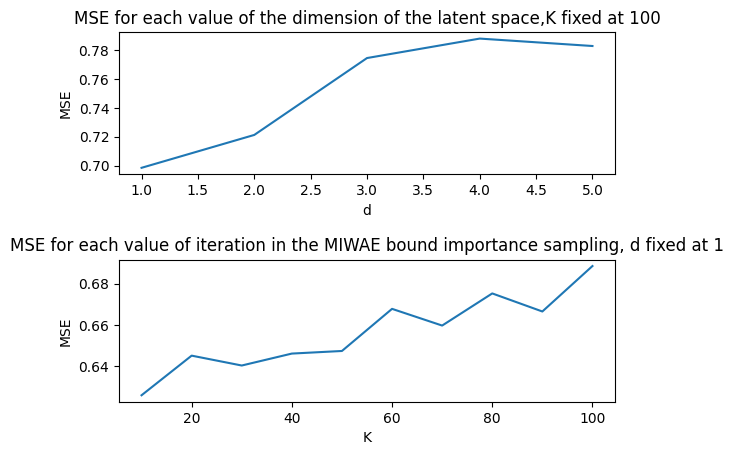

In [15]:
optimize_MIWAE_param(d_array=np.linspace(1,5,5),K_array=np.linspace(10,100,10),full_data=X_1,miss_data=opti_std_1,mask=mask_std_1)

The minimum mse value is obtained for a dimension of the latent space d: 1 and a number of iteration for the importance sampling of the MIWAE bound construction K :10.0


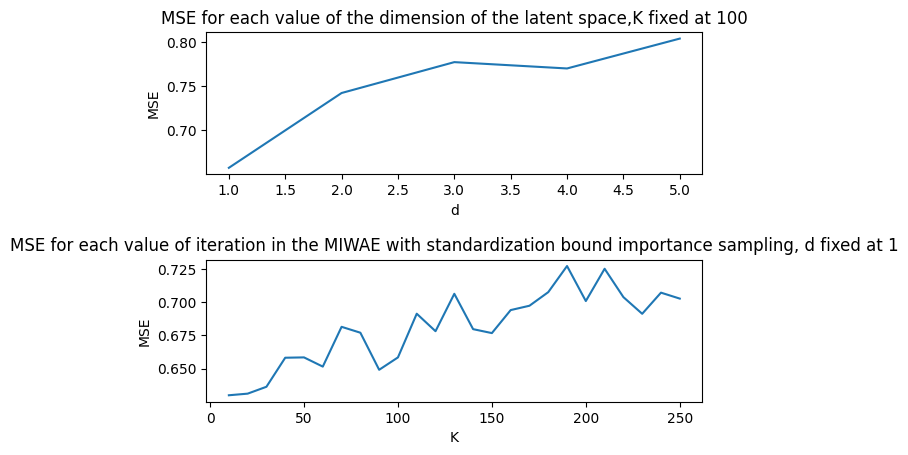

In [16]:
optimize_MIWAE_std_param(d_array=np.linspace(1,5,5),K_array=np.linspace(10,250,25),full_data=X_1,miss_data=opti_std_1,mask=mask_std_1)

The minimum mse value is obtained for a learning rate : 0.0011


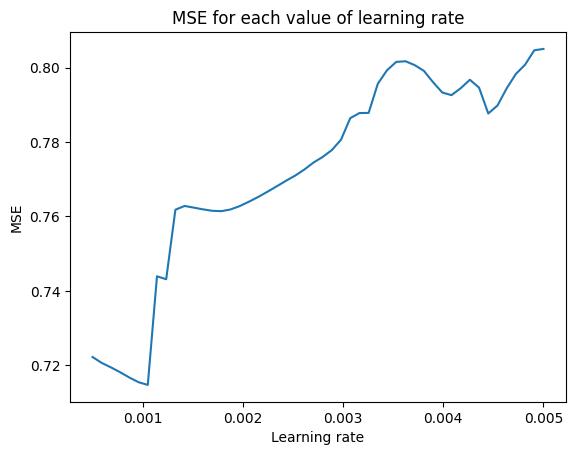

In [17]:
optimize_MIDA_param(lr_array=np.linspace(0.005,0.0005,50),full_data=X_1,miss_data=opti_std_1,mask=mask_std_1)

The minimum mse value is obtained for a number of trees in the forest of : 38.0


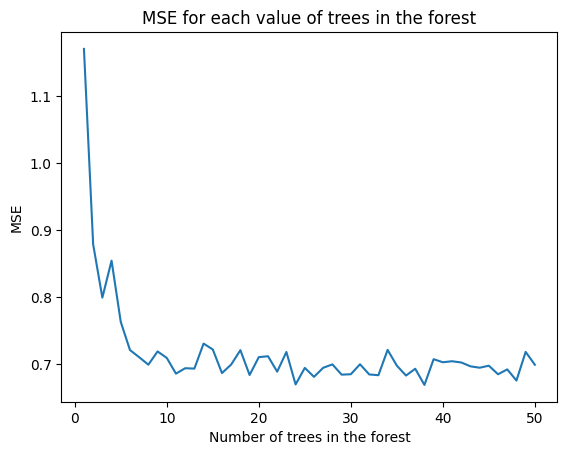

In [18]:
optimize_RF_param(n_est_array=np.linspace(1,50,50),full_data=X_1,miss_data=opti_std_1,mask=mask_std_1)

In [20]:
mech_1=["mar","mnar"]
meth_1=["MIWAE","MIWAE_standardization","MIDA","RF"]
prop_1=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
sim_1=10
M_1=1000


# MIDA 

la_1= [64,64,64] 
lr_1=0.0011
in_1=0.8
trb_1=32
tr_1=100
MIDA_1=[la_1,lr_1,in_1,trb_1,seed_1,tr_1]

# MIWAE
d_1=1
h_1=64
K_1=10
tr_M_1=501
MIWAE_1=[d_1,h_1,K_1,tr_M_1]
# MIWAE standardization

d_str_1=1
h_str_1=64
K_str_1=10
tr_M_str_1=501
MIWAE_std_1=[d_str_1,h_str_1,K_str_1,tr_M_str_1]

# RF
iter_1=10
est_1=38
RF_1=[iter_1,est_1]



In [21]:
exp1_res_std,exp1_bonxplot_std=comparison_std(full_data=exp_1,missing_mecha=mech_1,prop_NA=prop_1,comp_methods=meth_1,nb_simu=sim_1,M=M_1,device=device,Mida_param=MIDA_1,Rf_param=RF_1,Miwae_param=MIWAE_1,Miwae_std_param=MIWAE_std_1,save=False)

MAR
Computation for 10.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 20.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 30.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 40.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 50.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 60.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 70.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 80.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 90.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
MNAR
Computation for 10.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 20.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 30.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 40.

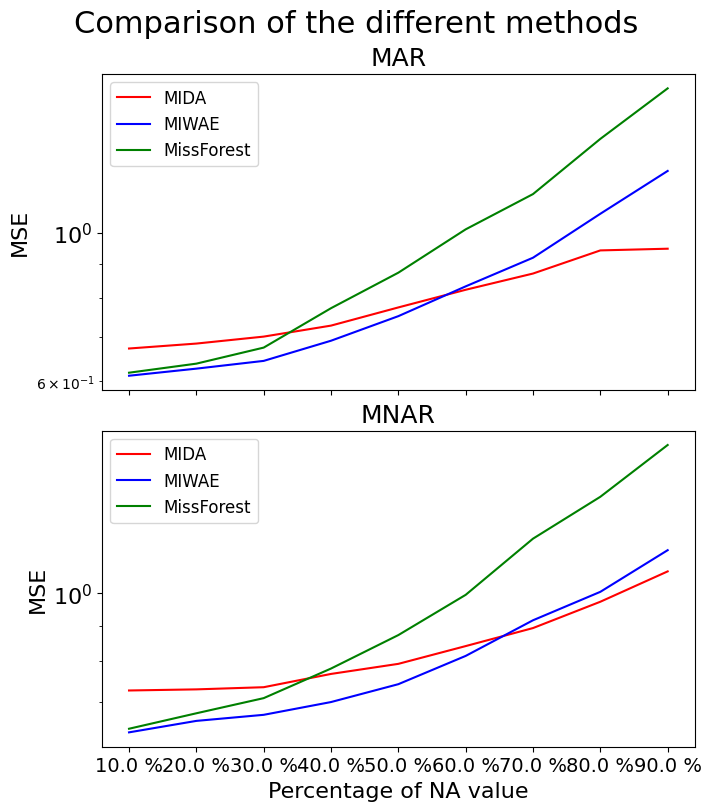

In [24]:
plot_result(exp1_res_std,comp_meth=["MIDA","MIWAE","RF"],save=True,name="standardization_after_sans_miwae_std.png")

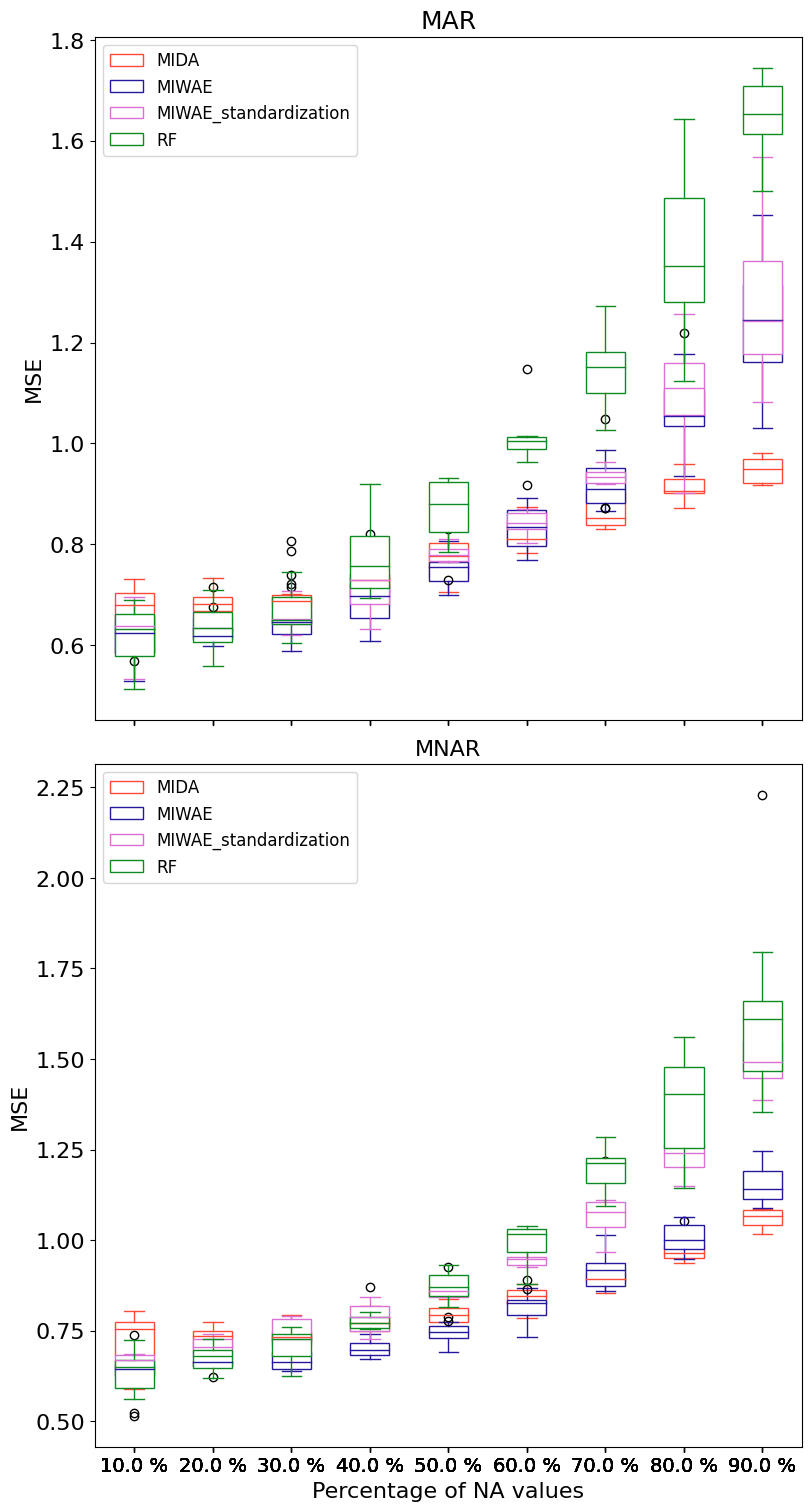

In [29]:
boxplot_results(results=exp1_bonxplot_std,meth=["MIWAE","MIDA","RF","MIWAE_standardization"],prop_l=prop_1,mech=mech_1,save=True,name="bp_aft_std.png")

# Exp 2 

In [173]:
from comparison_tools import *

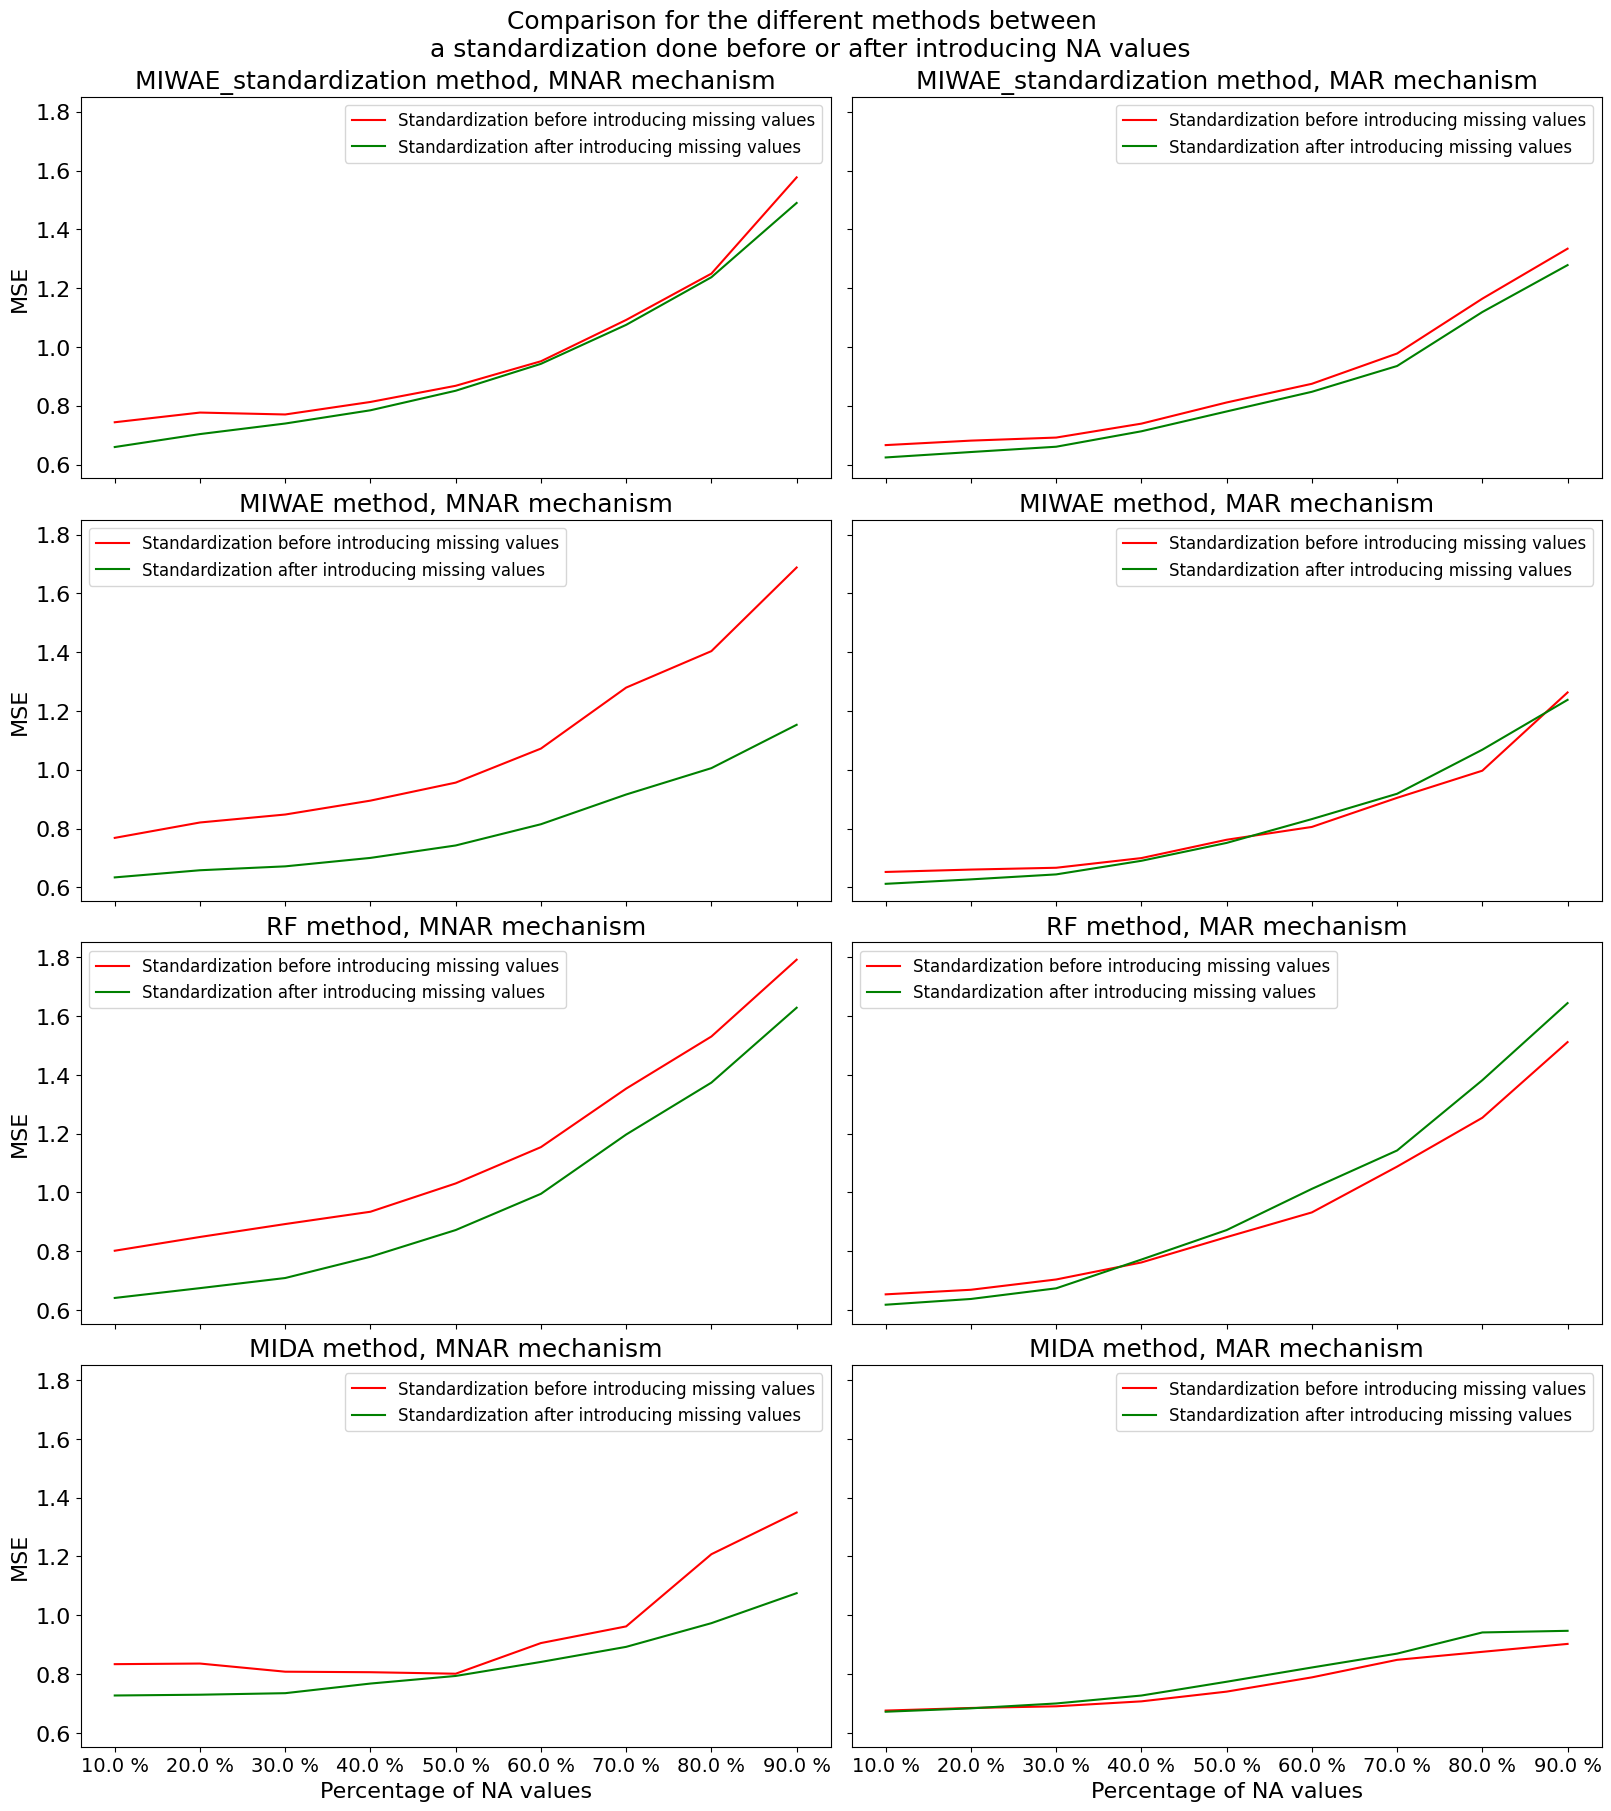

In [23]:
plot_comparison_std(exp1_res,exp1_res_std,method=["MIWAE_standardization","MIWAE","RF","MIDA"],mech=["MNAR","MAR"],save=True,name="comparison_with_without_std.png")

In [175]:
seed_2=154
n_2=300
cov_2=8
var_2=0.9
k_2=0.6
mod_2="linear"
mu_2=[52,-8]
Sigma_2=np.array([[1,0.01],[0.01,12]])
exp_2=pd.DataFrame(create_complete_dataset(seed=seed_2,n=n_2,c=cov_2,modSimu=mod_2,Sigma=Sigma_2,mu=mu_2,noise=var_2,k=k_2))
xcomp=(exp_2-np.mean(exp_2,0))/np.std(exp_2,0)

In [176]:
opti_2_tmp,mask_2=missing_method(raw_data=exp_2,mechanism="mar",t=0.4)
opti_2=(opti_2_tmp-np.nanmean(opti_2_tmp,0))/np.nanstd(opti_2_tmp,0)

The minimum mse value is obtained for a dimension of the latent space d: 2 and a number of iteration for the importance sampling of the MIWAE bound construction K :10.0


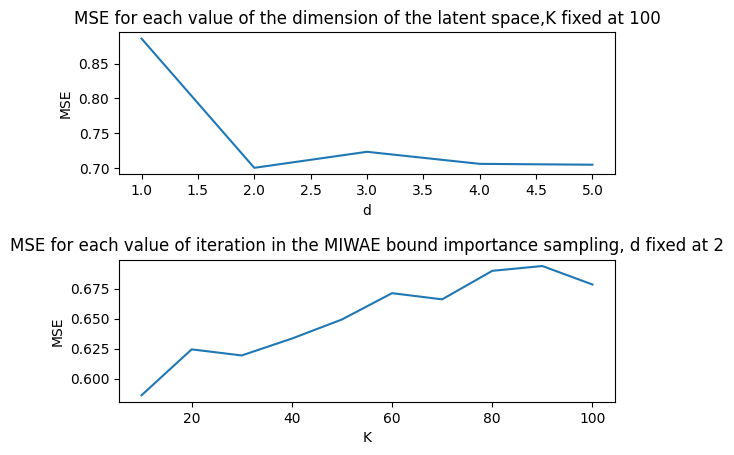

In [18]:
optimize_MIWAE_param(d_array=np.linspace(1,5,5),K_array=np.linspace(10,100,10),full_data=xcomp,miss_data=opti_2,mask=mask_2)

The minimum mse value is obtained for a dimension of the latent space d: 3 and a number of iteration for the importance sampling of the MIWAE bound construction K :10.0


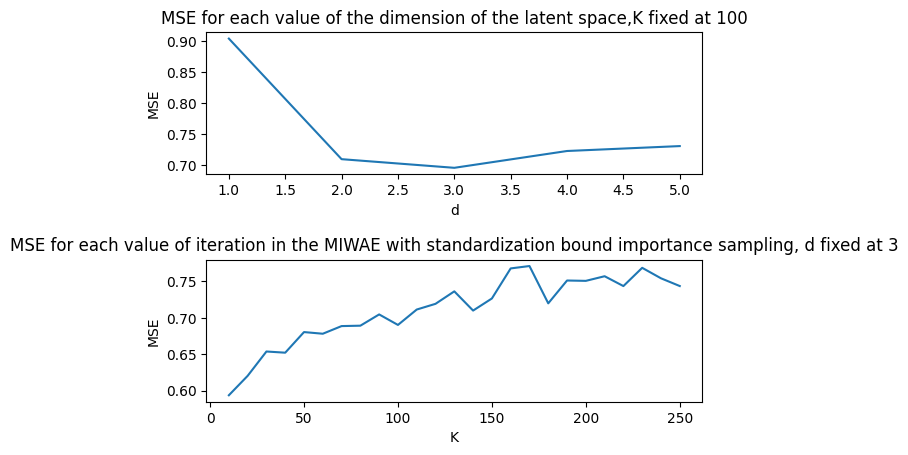

In [19]:
optimize_MIWAE_std_param(d_array=np.linspace(1,5,5),K_array=np.linspace(10,250,25),full_data=xcomp,miss_data=opti_2,mask=mask_2)

In [17]:
mech_2=["mar"]
meth_2=["MIWAE","MIWAE_standardization"]
prop_2=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
sim_2=10
M_2=1000
# MIWAE
d_2=2
h_2=64
K_2=10
tr_M_2=501
MIWAE_2=[d_2,h_2,K_2,tr_M_2]
# MIWAE standardization

d_std_2=3
h_std_2=64
K_std_2=10
tr_M_std_2=501
MIWAE_std_2=[d_std_2,h_std_2,K_std_2,tr_M_std_2]


# 

In [18]:
exp2_res,exp2_boxplot=comparison_std(full_data=exp_2,missing_mecha=mech_2,prop_NA=prop_2,comp_methods=meth_2,nb_simu=sim_2,M=M_2,device=device,Miwae_param=MIWAE_2,Miwae_std_param=MIWAE_std_2,save=False)


MAR
Computation for 10.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 20.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 30.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 40.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 50.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 60.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 70.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 80.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 90.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done


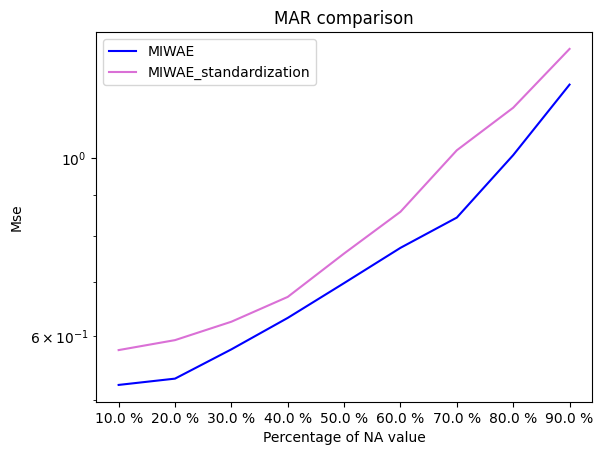

In [19]:
plot_result(exp2_res,comp_meth=meth_2,save=True,name="low_corr_miwae_comp.png")

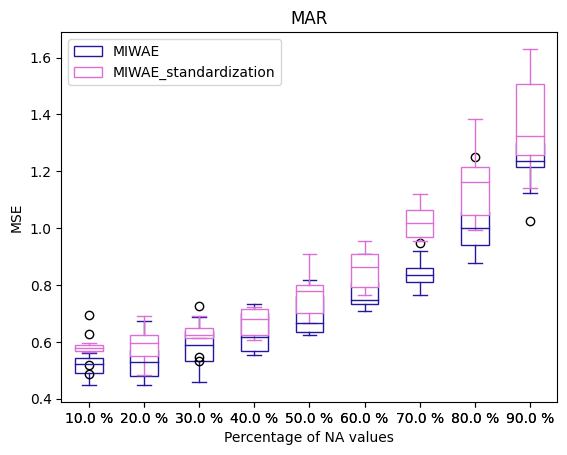

In [20]:
boxplot_results(results=exp2_boxplot,meth=meth_2,prop_l=prop_2,mech=mech_2,save=True,name="low_corr_bp_miwe_comp.png")

## Exp 3

In [19]:
seed_3=1754
n_3=300
cov_3=8
var_3=0.9
k_3=0.6
mod_3="linear"
mu_3=[7,-4]
Sigma_3=np.array([[11,0.99],[0.99,0.8]])
exp_3=pd.DataFrame(create_complete_dataset(seed=seed_3,n=n_3,c=cov_3,modSimu=mod_3,Sigma=Sigma_3,mu=mu_3,noise=var_3,k=k_3))
xcomp_3=(exp_3-np.mean(exp_3,0))/np.std(exp_3,0)

In [20]:
opti_3_tmp,mask_3=missing_method(raw_data=exp_3,mechanism="mar",t=0.4)
opti_3=(opti_3_tmp-np.nanmean(opti_3_tmp,0))/np.nanstd(opti_3_tmp,0)

The minimum mse value is obtained for a dimension of the latent space d: 3 and a number of iteration for the importance sampling of the MIWAE bound construction K :10.0


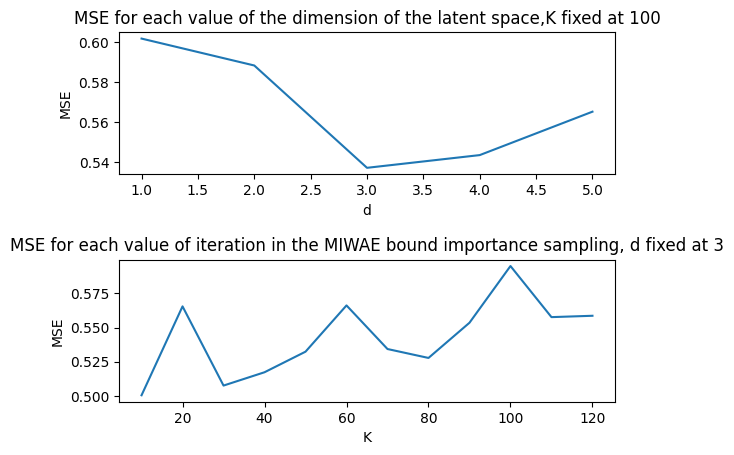

In [23]:
optimize_MIWAE_param(d_array=np.linspace(1,5,5),K_array=np.linspace(10,120,12),full_data=xcomp_3,miss_data=opti_3,mask=mask_3)

The minimum mse value is obtained for a dimension of the latent space d: 2 and a number of iteration for the importance sampling of the MIWAE bound construction K :30.0


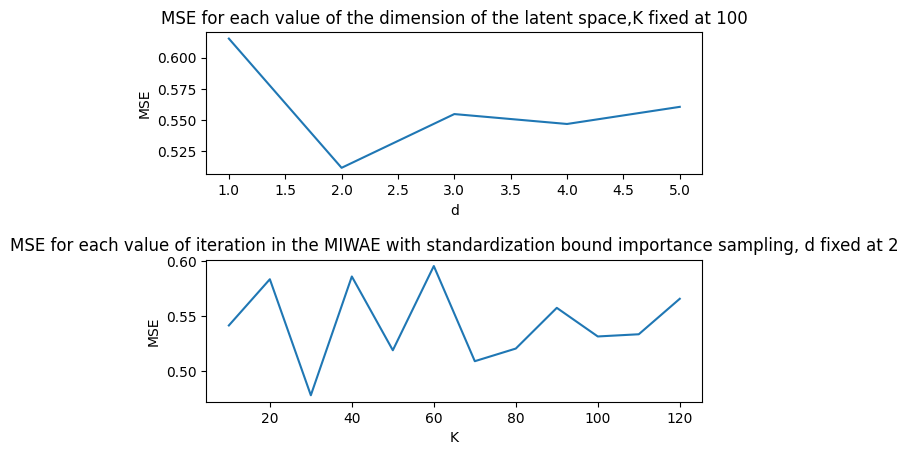

In [24]:
optimize_MIWAE_std_param(d_array=np.linspace(1,5,5),K_array=np.linspace(10,120,12),full_data=xcomp_3,miss_data=opti_3,mask=mask_3)

In [26]:
mech_3=["mar"]
meth_3=["MIWAE","MIWAE_standardization"]
prop_3=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
sim_3=10
M_3=1000
# MIWAE
d_3=3
h_3=64
K_3=10
tr_M_3=501
MIWAE_3=[d_3,h_3,K_3,tr_M_3]
# MIWAE standardization

d_std_3=2
h_std_3=64
K_std_3=30
tr_M_std_3=501
MIWAE_std_3=[d_std_3,h_std_3,K_std_3,tr_M_std_3]


In [27]:
exp3_res,exp3_boxplot=comparison_std(full_data=exp_3,missing_mecha=mech_3,prop_NA=prop_3,comp_methods=meth_3,nb_simu=sim_3,M=M_3,device=device,Miwae_param=MIWAE_3,Miwae_std_param=MIWAE_std_3,save=False)


MAR
Computation for 10.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 20.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 30.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 40.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 50.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 60.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 70.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 80.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done
Computation for 90.0 % of NA values
Simulation 1-5 done
Simulation 6-10 done


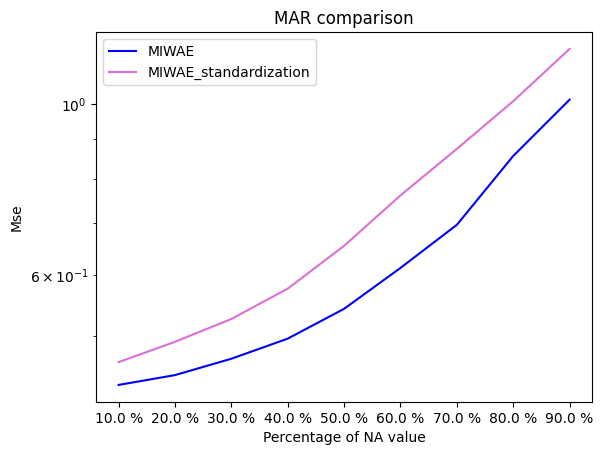

In [28]:
plot_result(exp3_res,comp_meth=meth_3)

In [148]:
exp3_res["MAR"].loc["MIWAE"]

10.0 %    0.432720
20.0 %    0.445571
30.0 %    0.467833
40.0 %    0.496708
50.0 %    0.542837
60.0 %    0.613151
70.0 %    0.697105
80.0 %    0.855790
90.0 %    1.012048
Name: MIWAE, dtype: float64

In [63]:
plot_comparison_std(results=exp1_res,results_std=exp1_res_std,method="MIWAE",mech="MAR")

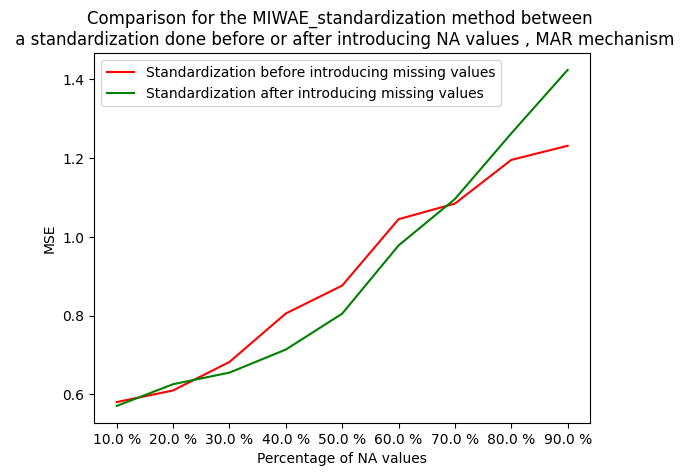

In [37]:
plot_comparison_std(results=exp1_res,results_std=exp1_res_std,method="MIWAE_standardization",mech="MAR")

## Real dataset 

In [7]:
from sklearn.datasets import load_breast_cancer
data_tmp = load_breast_cancer()
data=pd.DataFrame(data_tmp.data)


In [8]:
data_std=(data-np.mean(data,0))/np.std(data,0)

In [9]:
opti_4,mask_4=missing_method(raw_data=data_std,mechanism="mar",t=0.4)

The minimum mse value is obtained for a dimension of the latent space d: 7 and a number of iteration for the importance sampling of the MIWAE bound construction K :10.0


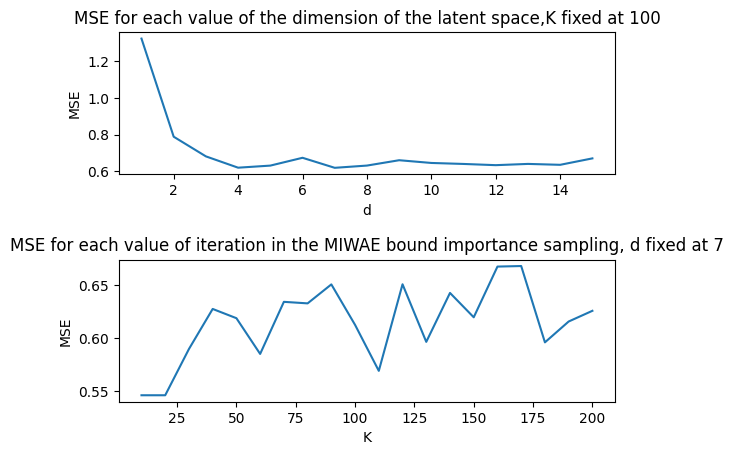

In [10]:
optimize_MIWAE_param(d_array=np.linspace(1,15,15),K_array=np.linspace(10,200,20),full_data=data_std,miss_data=opti_4,mask=mask_4)

The minimum mse value is obtained for a dimension of the latent space d: 7 and a number of iteration for the importance sampling of the MIWAE bound construction K :10.0


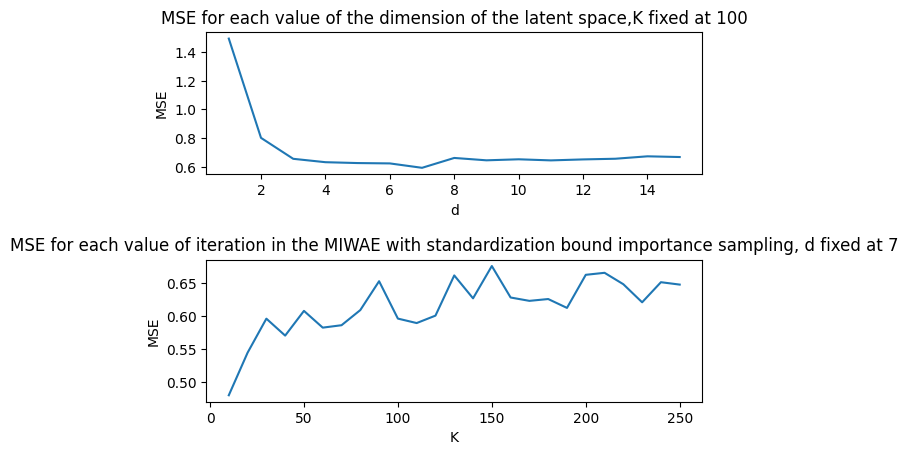

In [11]:
optimize_MIWAE_std_param(d_array=np.linspace(1,15,15),K_array=np.linspace(10,250,25),full_data=data_std,miss_data=opti_4,mask=mask_4)

In [14]:
mech_4=["mar","mnar"]
meth_4=["MIWAE","MIWAE_standardization"]
prop_4=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
sim_4=10
M_4=1000
# MIWAE
d_4=7
h_4=64
K_4=10
tr_M_4=501
MIWAE_4=[d_4,h_4,K_4,tr_M_4]
# MIWAE standardization

d_std_4=7
h_std_4=64
K_std_4=10
tr_M_std_4=501
MIWAE_std_4=[d_std_4,h_std_4,K_std_4,tr_M_std_4]


In [15]:
exp4_res,exp4_boxplot=comparison(full_data=data_std,missing_mecha=mech_4,prop_NA=prop_4,comp_methods=meth_4,nb_simu=sim_4,M=M_4,device=device,Miwae_param=MIWAE_4,Miwae_std_param=MIWAE_std_4,save=False)


MAR
Computation for 10.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 20.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 30.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 40.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 50.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 60.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 70.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 80.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 90.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
MNAR
Computation for 10.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 20.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 30.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 40.

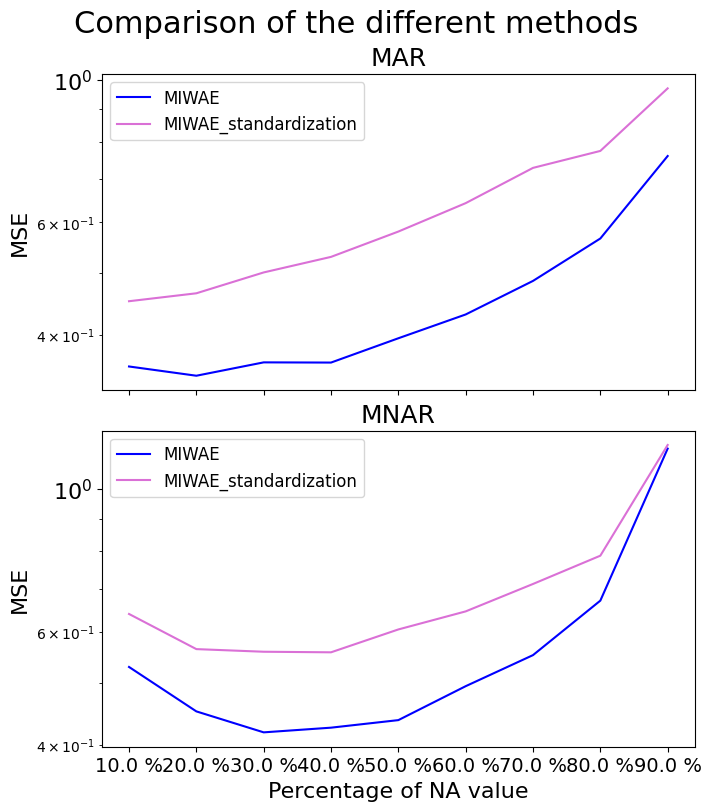

In [16]:
plot_result(exp4_res,comp_meth=meth_4,save=True,name="breast_miwae_comp.png")

In [17]:
opti_std_4_tmp,mask_std_4=missing_method(raw_data=data,mechanism="mar",t=0.4)

In [18]:
opti_std_4=(opti_std_4_tmp-np.nanmean(opti_std_4_tmp,0))/np.nanstd(opti_std_4_tmp,0)

The minimum mse value is obtained for a dimension of the latent space d: 6 and a number of iteration for the importance sampling of the MIWAE bound construction K :10.0


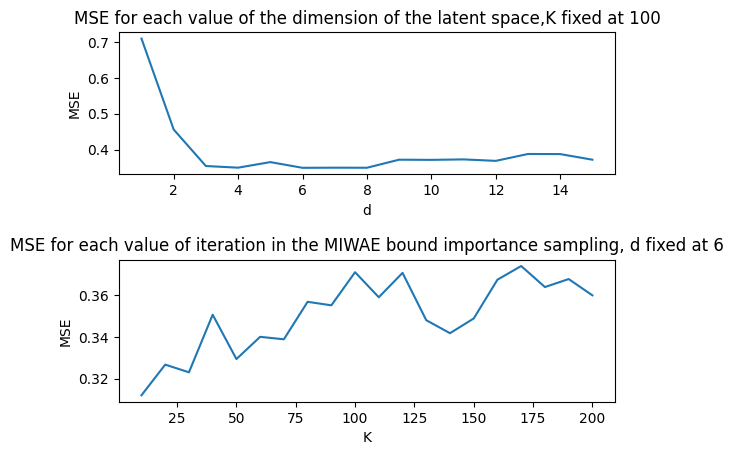

In [19]:
optimize_MIWAE_param(d_array=np.linspace(1,15,15),K_array=np.linspace(10,200,20),full_data=data_std,miss_data=opti_std_4,mask=mask_4)

The minimum mse value is obtained for a dimension of the latent space d: 6 and a number of iteration for the importance sampling of the MIWAE bound construction K :10.0


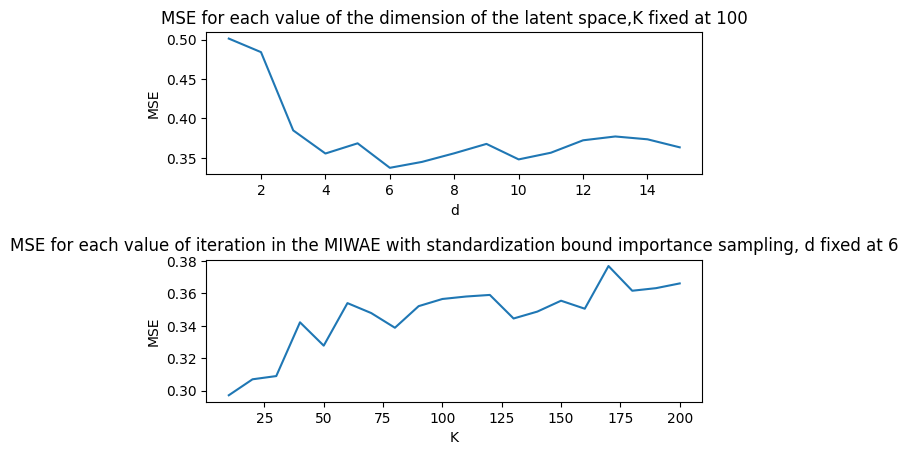

In [20]:
optimize_MIWAE_std_param(d_array=np.linspace(1,15,15),K_array=np.linspace(10,200,20),full_data=data_std,miss_data=opti_std_4,mask=mask_4)

In [22]:
mech_4=["mar","mnar"]
meth_4=["MIWAE","MIWAE_standardization"]
prop_4=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
sim_4=10
M_4=1000
# MIWAE
d_4=6
h_4=64
K_4=10
tr_M_4=501
MIWAE_4=[d_4,h_4,K_4,tr_M_4]
# MIWAE standardization

d_std_4=6
h_std_4=64
K_std_4=10
tr_M_std_4=501
MIWAE_std_4=[d_std_4,h_std_4,K_std_4,tr_M_std_4]


In [23]:
exp5_res,exp5_boxplot=comparison_std(full_data=data,missing_mecha=mech_4,prop_NA=prop_4,comp_methods=meth_4,nb_simu=sim_4,M=M_4,device=device,Miwae_param=MIWAE_4,Miwae_std_param=MIWAE_std_4,save=False)


MAR
Computation for 10.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 20.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 30.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 40.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 50.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 60.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 70.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 80.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
Computation for 90.0 % of NA values
Simulation 1 - 5 done
Simulation 6 - 10 done
MNAR
Computation for 10.0 % of NA values


ValueError: f(a) and f(b) must have different signs

# Choose threshold

In [53]:
def choose_threshold(data,thresh_list,NA_prop=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],mech="mnar",device=device,save=False,name=None,nb_simu=10):
    xcomp=(data-np.mean(data,0))/np.std(data,0)
    legend=[]
    mse_miwae=[]
    perc_NA=[" ".join([str(prop*100),"%"]) for prop in NA_prop]
    for prop in NA_prop:
        mse_miwae_1=[]
        for i in range(nb_simu):
            seed=i
            np.random.seed(seed)
            torch.manual_seed(seed)
            torch.cuda.seed()
            tf.random.set_seed(seed)
            miss_tmp,mask=missing_method(data,mech,prop)
            miss=(miss_tmp-np.nanmean(miss_tmp,0))/np.nanstd(miss_tmp,0)
            n,p=miss.shape
            miss_miw=miss.copy()
            p_z=prior(d=5,device=device)
            encoder,decoder=build_encoder_decoder(p,h=64,d=5)
            optimizer=build_optimizer(encoder=encoder,decoder=decoder)
            m=train_MIWAE(encoder=encoder,decoder=decoder,optimizer=optimizer,d=5,p_z=p_z,miss_data=miss_miw,raw_data=xcomp,device=device,K=10,verbose=False,n_epochs=501)
            Miwae_imputations=miwae_multiple_impute(data=miss_miw,encoder=encoder,decoder=decoder,d=5,p=p,p_z=p_z,device=device,M=1000)
            tmp_mse_miwae=avg_mse(list_imp=Miwae_imputations,xtrue=xcomp,mask=mask)
            mse_miwae_1.append(tmp_mse_miwae)
        mse_miwae.append(np.mean(mse_miwae_1))
    f,ax=plt.subplots()
    ax.plot(perc_NA,mse_miwae)
    legend+=["MIWAE"]
    for thresh in thresh_list:
        mse_miwae_std=[]
        for prop in NA_prop:
            mse_miwae_std_1=[]
            for i in range(nb_simu):
                seed=i
                np.random.seed(seed)
                torch.manual_seed(seed)
                torch.cuda.seed()
                tf.random.set_seed(seed)
                miss_tmp,mask=missing_method(data,mech,prop)
                miss=(miss_tmp-np.nanmean(miss_tmp,0))/np.nanstd(miss_tmp,0)
                n,p=miss.shape
                miss_miw_std=miss.copy()
                p_z_std=prior(d=5,device=device)
                encoder_std,decoder_std=build_encoder_decoder(p,h=64,d=5)
                optimizer_std=build_optimizer(encoder=encoder_std,decoder=decoder_std)
                m=train_MIWAE_standardization(encoder=encoder_std,decoder=decoder_std,optimizer=optimizer_std,d=5,p_z=p_z_std,miss_data=miss_miw_std,mean_0=np.nanmean(miss,0),std_0=np.nanstd(miss,0),raw_data=xcomp,device=device,thr=thresh,K=10,verbose=False,n_epochs=501)
                Miwae_std_imputations=miwae_multiple_impute(data=miss_miw_std,encoder=encoder_std,decoder=decoder_std,d=5,p=p,p_z=p_z_std,device=device,M=1000)
                tmp_mse_miwae_std=avg_mse(list_imp=Miwae_std_imputations,xtrue=xcomp,mask=mask)
                mse_miwae_std_1.append(tmp_mse_miwae_std)
            mse_miwae_std.append(np.mean(mse_miwae_std_1))
        ax.plot(perc_NA,mse_miwae_std)
        legend+=[" ".join(["Threshold =",str(thresh)])]
    ax.legend(legend)
    ax.set_xlabel("Percentage of NA values")
    ax.set_ylabel("MSE")
    ax.set_title("Comparison between MIWAE and MIWAE standardization \n for different values of threshold")
    if save :
        directory = os.getcwd()
        tmp_fig_path="\ ".join([directory,name])
        fig_path=tmp_fig_path.replace(" ","")
        plt.savefig(fig_path)
    plt.show()        

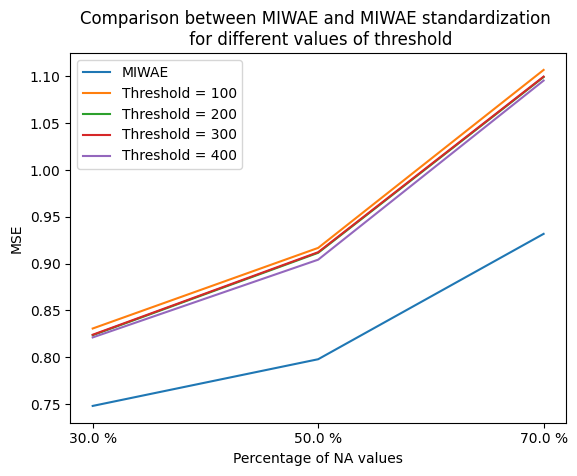

In [56]:
choose_threshold(exp_1,[100,200,300,400])